## Square Attack
The Square Attack is a black-box method used to generate adversarial examples. It differs from previously discussed white-box approaches (like CW or PGD) due to not requiring knowledge of model weights to fool the model. It generally consists of trying a random alteration on a decreasing 'square' of the image, and keeping it if it increases the loss of the model. The $ L_\infty $ and $ L_2. $ approaches use different sampling distributions to change pixel values in the squares.



## 1. Loading and Processing Models and Images

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

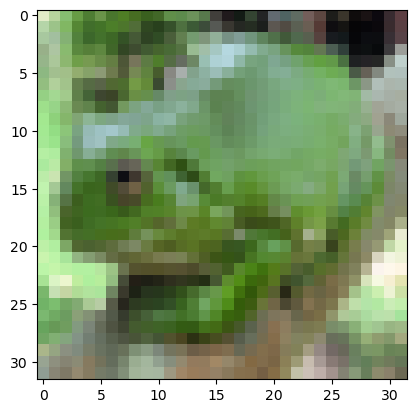

In [160]:
from utils_test import prediction, process_image, show_image, SimpleCNN, CIFAR10
import torch
import numpy as np
import random

show_image(process_image('frog.jpg'))
model = SimpleCNN()
classes = CIFAR10().classes
model.load_state_dict(torch.load('CNN_weights.pth'))
model.eval()

## 2. The $ L_\infty $ Attack

### Task 1
First, we will start by making a helper function for the $ L_\infty $ attack. This will be the function for creating the distribution used to alter squares.

<strong>Algorithm 2:</strong> Sampling distribution $P$ for $l_\infty$-norm
<hr>
<strong>Input:</strong> maximal norm $\epsilon$, window size $h$, image size $w$, color channels $c$<br>
<strong>Output:</strong> New update $\delta$
<hr>

<table align='left'>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">1</td>
    <td>$\delta \leftarrow \text{array of zeros of size } w \times w \times c$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">2</td>
    <td>sample uniformly<br>$r, s \in \{0, \dots, w - h\} \subset \mathbb{N}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">3</td>
    <td><b>for</b> $i = 1, \dots, c$ <b>do</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">4</td>
    <td style="padding-left: 2em;">$\rho \leftarrow \text{Uniform}(\{-2\epsilon, 2\epsilon\})$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">5</td>
    <td style="padding-left: 2em;">$\delta_{r+1:r+h, s+1:s+h, i} \leftarrow \rho \cdot \mathbf{1}_{h \times h}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">6</td>
    <td><b>end</b></td>
  </tr>
</table>

<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution we use ```torch.zeros``` to create a null matrix of the right shape and then add the individual values.

</details>
<details>
<summary>💡 <b>Hint for Task #1</b></summary>

In our solution, we index for the window using:
```arr[a:b+c][d:e+f]```

</details>

<details>
<summary>🔐 <b>Solution for Task #1</b></summary>

```python
def l_inf_dist(epsilon, h, w, c):
    """Calculates the delta update for l_inf distribution.
    
    Args:
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor containing updates for each channel.
    """
    delta = torch.zeros(c, w, w)
    r,s = np.random.randint(32-h, size = (2))
    for channel in range(c):
        unif = np.random.uniform(-2*epsilon, 2*epsilon)
        delta[channel][r:r+h, s:s+h] = unif
    return delta
```

</details>

In [29]:
def l_inf_dist(epsilon, h, w, c):
    """Calculates the delta update for l_inf distribution.
    
    Args:
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    """
    return None

## 2.1 The Square Attack loop.
### Task 2
Now, we will use the distribution within the main loop of the  $ L_\infty $ attack. Virtually the same code can be used for the $ L_2 $ attack.

<hr>
<strong>Input:</strong> classifier $f$, point $x \in \mathbb{R}^d$, image size $w$, number of color channels $c$,<br>
$l_p$-radius $\epsilon$, label $y \in \{1, \dots, K\}$, number of iterations $N$<br>
<strong>Output:</strong> approximate minimizer $\hat{x} \in \mathbb{R}^d$ of the problem stated in Eq. (1)
<hr>

<table align='left'>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">1</td>
    <td>$\hat{x} \leftarrow \text{init}(x), \quad l^* \leftarrow L(f(x), y), \quad i \leftarrow 1$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">2</td>
    <td><b>while</b> $i < N$ and $\hat{x}$ is not adversarial <b>do</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">3</td>
    <td style="padding-left: 2em;">$h^{(i)} \leftarrow$ side length of the square to modify (according to some schedule)</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">4</td>
    <td style="padding-left: 2em;">$\delta \sim P(\epsilon, h^{(i)}, w, c, \hat{x}, x)$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">5</td>
    <td style="padding-left: 2em;">$\hat{x}_{\text{new}} \leftarrow \text{Project } \hat{x} + \delta \text{ onto } \{z \in \mathbb{R}^d : \|z - x\|_p \le \epsilon\} \cap [0, 1]^d$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">6</td>
    <td style="padding-left: 2em;">$l_{\text{new}} \leftarrow L(f(\hat{x}_{\text{new}}), y)$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">7</td>
    <td style="padding-left: 2em;"><b>if</b> $l_{\text{new}} < l^*$ <b>then</b> $\hat{x} \leftarrow \hat{x}_{\text{new}}, l^* \leftarrow l_{\text{new}};$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">8</td>
    <td style="padding-left: 2em;">$i \leftarrow i + 1$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">9</td>
    <td><b>end</b></td>
  </tr>
</table>



<details>
<summary>💡 <b>Hint for Task #2</b></summary>

In our solution, we use the div operator, ```//``` for the floor function.
</details>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=1/1000):
    """Creates an adversarial example for the l_inf distribution.
    
    Args:
        model: Trained neural network model with forward pass.
        loss_fn: Loss function used to train the network model.
        x: Input image tensor
        y: Label for input tensor
        N: Max number of iterations
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
        epsilon: Small number used for peturbation
    
    Returns:
        adv_img: Adversarially perturbed image tensor
    """
    
    x_hat = x
    loss = loss_fn(model(x), y)
    i = 1
    h = 25
    while i < N and prediction(model, x_hat)[0] == y:
        if i % N // h == 0:
            h -= 1
        delta = l_inf_dist(h=h, epsilon=0.002, w=w, c=c)
        x_new = x_hat + delta
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat

```

</details>

A basic schedule could involve reducing h by one every N/h iterations.

In [36]:
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=1/1000):
    """Creates an adversarial example for the l_inf distribution.
    
    Args:
        model: Trained neural network model with forward pass.
        loss_fn: Loss function used to train the network model.
        x: Input image tensor
        y: Label for input tensor
        N: Max number of iterations
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
        epsilon: Small number used for peturbation
    
    Returns:
        adv_img: Adversarially perturbed image tensor
    """
    return None

In [ ]:
img = process_image('frog.jpg')
label = prediction(model, process_image('frog.jpg'))[0]
loss_fn = torch.nn.CrossEntropyLoss()
x_adv = l_inf_square_attack(model, loss_fn, img, label, 500)

pred = prediction(model, x_adv)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")
show_image(x_adv)

## 3. The $ L_2 $ Attack
While the main loop of this attack is the same as the above, the distribution is entirely different. We will begin by producing the helper functions for this, and then the function itself.

### Task 3
Code the M helper function for $L_2$ distribution

$
M(r, s) = n - \max\{|r - \lfloor \frac{h_1}{2} \rfloor - 1|, |s - \lfloor \frac{h_2}{2} \rfloor - 1|\}
$

$where$ $n =  \lfloor \frac{h_1}{2}  \rfloor $


<details>
<summary>💡 <b>Hint for Task #3</b></summary>

In our solution, we use the div operator, ```//``` for the floor function.
</details>


<details>
<summary>🔐 <b>Solution for Task #3</b></summary>

```python
def M(r, s, h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        r: X coordinate
        s: Y coordinate
        h1: Square size
        h2: Floor of half Square size

    Returns:
        M: Calculated M value
    """
    n = h1 // 2
    return max(abs(r - h1 // 2 - 1), abs(s - h2 // 2 - 1))
```

</details>

In [47]:
def M(r, s, h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        r: X coordinate
        s: Y coordinate
        h1: Square size
        h2: Floor of half Square size

    Returns:
        M: Calculated M value
    """
    return None

### Task 4
Code the eta helper function for the $L_2$ distribution

$
\eta_{r,s}^{(h_1,h_2)} = \sum_{k=0}^{M(r,s)} \frac{1}{(n+1-k)^2}
$

<details>
<summary>💡 <b>Hint for Task #4</b></summary>

In our solution, we use a cache for faster computation, but this is not necessary.
</details>


<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python
def eta(h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        h1: Square size
        h2: Floor of half Square size

    Returns:
        eta: Calculated eta tensor
    """
    n = h1 // 2
    m_matrix = torch.tensor([[M(i, j, h1, h2) for i in range(h2)] for j in range(h1)])
    max_value = torch.max(m_matrix)
    cache = []
    t_sum = 0
    for i in range(max_value):
        if n+1-i != 0: 
            t_sum += 1 / (n+1-i)
        cache.append(t_sum)
    cache = torch.tensor(cache)
    eta_matrix = cache[m_matrix - 1]
    return eta_matrix
```

</details>

In [57]:
def eta(h1, h2):
    """Helper function for L2 dist calculation
    
    Args:
        h1: Square size
        h2: Floor of half Square size

    Returns:
        eta: Calculated eta tensor
    """
    return None

### Task 5
Now code the L_2 distribution using the above helper functions.

<hr>
<strong>Input:</strong> maximal norm $\epsilon$, window size $h$, image size $w$, number of color channels $c$, current image $\hat{x}$, original image $x$<br>
<strong>Output:</strong> New update $\delta$
<hr>

<table align='left'>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">1</td>
    <td>$\nu \leftarrow \hat{x} - x$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">2</td>
    <td>sample uniformly $r_1, s_1, r_2, s_2 \in \{0, \dots, w - h\}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">3</td>
    <td>$W_1 := r_1 + 1 : r_1 + h, s_1 + 1 : s_1 + h, W_2 := r_2 + 1 : r_2 + h, s_2 + 1 : s_2 + h$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">4</td>
    <td>$\epsilon^2_{\text{unused}} \leftarrow \epsilon^2 - \|\nu\|_2^2, \quad \eta^* \leftarrow \eta / \|\eta\|_2 \text{ with } \eta \text{ as in (2)}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">5</td>
    <td><b>for</b> $i = 1, \dots, c$ <b>do</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">6</td>
    <td style="padding-left: 2em;">$\rho \leftarrow \text{Uniform}(\{-1, 1\})$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">7</td>
    <td style="padding-left: 2em;">$\nu_{\text{temp}} \leftarrow \rho\eta^* + \frac{\nu_{W_1, i}}{\|\nu_{W_1, i}\|_2}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">8</td>
    <td style="padding-left: 2em;">$\epsilon^i_{\text{avail}} \leftarrow \sqrt{\|\nu_{W_1 \cup W_2, i}\|_2^2 + \frac{\epsilon^2_{\text{unused}}}{c}}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">9</td>
    <td style="padding-left: 2em;">$\nu_{W_2, i} \leftarrow 0, \quad \nu_{W_1, i} \leftarrow \left( \frac{\nu_{\text{temp}}}{\|\nu_{\text{temp}}\|_2} \right) \epsilon^i_{\text{avail}}$</td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">10</td>
    <td><b>end</b></td>
  </tr>
  <tr>
    <td style="vertical-align: top; text-align: right; padding-right: 1em; user-select: none;">11</td>
    <td>$\delta \leftarrow x + \nu - \hat{x}$</td>
  </tr>
</table>


<details>
<summary>💡 <b>Hint for Task #5</b></summary>

Cloning v at the beginning can avoid a logic error (delta updates are 0 every time)
</details>

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

Adding a very small number to calculation denominators can avoid nan or infinity errors.
</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def l_2_dist(x_hat, x, epsilon = 1/1000, h = 10, w = 32, c = 3):
    """L_2 delta update calculation
    
    Args:
        x_hat: Altered image
        x: Original image
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    
    """
    v = x_hat - x
    v_new = v.clone()
    delta = torch.zeros(3,32,32)
    r1,s1,r2,s2 = np.random.randint(32-h, size = (4))
    v_sq = v ** 2
    eps_unused = max(0, epsilon ** 2 - torch.sum(v_sq))
    k = h // 2
    e1 = torch.hstack((eta(h, k), -1 * eta(h, h-k)))
    e2 = torch.hstack((eta(h, k), -1 * eta(h, h-k))).T
    e = random.choice([e1,e2])
    eta_star = e / (torch.norm(e, p=2) + 1e-9)
    for i in range(c):
        p = np.random.uniform(-1, 1)
        W1 = v[0][i, r1:r1+h, s1:s1+h]
        W2 = v[0][i, r2:r2+h, s2:s2+h]
        v_t = p * eta_star + W1 / (torch.norm(W1) + 1e-9)
        e_avail = torch.sqrt(torch.sum(W1 ** 2) + torch.sum(W2 ** 2) + eps_unused / 3)         
        v_new[0, i, r2:r2+h, s2:s2+h] = 0
        v_new[0, i, r1:r1+h, s1:s1+h] = (v_t / (torch.norm(v_t) + 1e-9)) * e_avail
    delta =  v_new - v
    return delta
```

</details>

In [156]:
def l_2_dist(x_hat, x, epsilon = 1/1000, h = 10, w = 32, c = 3):
    """L_2 delta update calculation
    
    Args:
        x_hat: Altered image
        x: Original image
        epsilon: Small number used for perturbation
        h: Dimension of square
        w: Image dimension (assumes image tensor is square)
        c: Number of colour channels (RGB is 3)
    Returns:
        delta: Tensor of the same size as input, containing updates for each channel.
    
    """
    return None

Now we implement the main loop for $L_2$ square attack. This is the same as the above $L_\infty$, but uses the other distribution. 

In [ ]:
def l_2_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=1/1000):
    x_hat = x.clone()
    loss = loss_fn(model(x), y)
    i = 1
    h = 25
    while i < N and prediction(model, x_hat)[0] == y:
        if i % N // h == 0:
            h -= 1
        delta = l_2_dist(x_hat, x, h=h, epsilon=0.002, w=w, c=c)
        x_new = x_hat + delta
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat

img = process_image('frog.jpg')
label = prediction(model, process_image('frog.jpg'))[0]
loss_fn = torch.nn.CrossEntropyLoss()
x_adv = l_2_square_attack(model, loss_fn, img, label, 500)

pred = prediction(model, x_adv)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")
show_image(x_adv)